#### Модель работающая в online IDE в Kaggle, но с легкостью можно запустить в локале, только установив LAMA(lightautoml) на python не выше 3.9


In [ ]:
# install LAMA for Kaggle 
%%capture
!pip install lightautoml
                    
# QUICK WORKAROUND FOR PROBLEM WITH PANDAS
!pip install -U pandas

In [2]:
from tqdm import tqdm
from tqdm import trange
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

import datetime
from collections import Counter
import category_encoders as ce
import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt

N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.25
TIMEOUT = 900 # equal to 15 minutes
TARGET_NAME = 'reviewer_score'

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [35]:
# загрузка данных
hotels_test = pd.read_csv('/media/oem/500/data/hotels_test.csv') 
hotels_train = pd.read_csv('/media/oem/500/data/hotels_train.csv') 
submission = pd.read_csv('/media/oem/500/data/submission.csv') 

In [36]:
# Объединяем трейн и тест в один датасет
print('объединяем', len(hotels_train))
hotels_train['sample'] = 1 # помечаем где у нас трейн
hotels_test['sample'] = 0 # помечаем где у нас тест
hotels_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = hotels_train.append(hotels_test, sort=False).reset_index(drop=True) # объединяем
print('после', len(hotels))

объединяем 386803


/tmp/ipykernel_10657/243869767.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = hotels_train.append(hotels_test, sort=False).reset_index(drop=True) # объединяем


после 515738


## Первый и основной этап создания признаков.

In [37]:
# добавление признаков
print('Старт', f'{datetime.datetime.now().hour}:{datetime.datetime.now().minute}:{datetime.datetime.now().second}')
count = 0
with trange(15) as t:
    for i in t:
        #(1) пометка дубликатов (dup)
        # не удаляем строки, а помечаем их отдельным признаком incorrect
        if count == 0:
            t.set_description('dupl incorrect (%i)' % i)
            t.set_postfix(str='добавление дубликатов в incorrect')  
            hotels_dd = hotels_train[hotels_train.duplicated ()]
            for ind in hotels_dd.index:
                hotels.loc[ind, 'incorrect'] = 1       
            count = 1
            continue
            
        #(2) пометка подозрительных\неверных строк (inc)
        # не удаляем строки, а помечаем их отдельным признаком incorrect
        elif count == 1:
            t.set_description('strn incorrect (%i)' % i)
            t.set_postfix(str='добавление подозрительных в incorrect')  
            list_hotel = hotels['hotel_name'].value_counts().index
            for name in list_hotel:
                dds = hotels[hotels['hotel_name']==name]
                country_top = hotels[hotels['hotel_name']==name]['reviewer_nationality'].value_counts().head(1).index
                for ind in dds.index:
                    if dds.loc[ind,'reviewer_nationality'] != country_top[0]:
                        hotels.loc[ind, 'incorrect'] = 1
            hotels['incorrect'] = hotels['incorrect'].fillna(0)         
            count = 2
            continue
            
        #(3) добавление выбросов в подозрительных\неверных строк (inc)
        # не удаляем строки, а помечаем их отдельным признаком incorrect
        elif count == 2:
            t.set_description('score_incorrect (%i)' % i)
            t.set_postfix(str='добавление выбросов в incorrect')  
            score_incorrect = [3.1, 4.4, 5.6, 6.9, 3.0, 8.1, 9.4, 3.5, 4.0, 4.5, 5.5, 6.0, 6.5, 7.0, 8.5, 8.0, 9.0, 9.5]
            ggg = []
            for score in score_incorrect:
                ind_score = hotels[hotels['reviewer_score']== score].index
                ggg.append(len(ind_score))
                for ind in ind_score:
                    hotels.loc[ind, 'incorrect'] = 1  
            count = 3
            continue

        #(4) преобразуем негативный отзыв в negative_false (nf3)
        # был произведен отбор максимально некорректных отзывов и сохранен в negative_false_v3.xlsx
        # после создан признак negative_false с некорректными
        elif count == 3:
            t.set_description('negative_false (%i)' % i)
            t.set_postfix(str='создание признака negative_false')            
            negative_false = pd.read_excel('/media/oem/500/data/negative_false_v3.xlsx')
            list_neg = list(negative_false['negative_review'])            
            def get_negative_false(args):
                if args in list_neg:
                    return 1
                else:
                    return 0
            hotels['negative_false'] = hotels['negative_review'].apply(get_negative_false) 
            count = 4
            continue

        #(5) преобразуем позитивный отзыв в positive_false (pf3)
        # был произведен отбор максимально некорректных отзывов и сохранен в positive_false_v3.xlsx
        # после создан признак positive_false с некорректными
        elif count == 4:
            t.set_description('positive_false (%i)' % i)
            t.set_postfix(str='создание признака positive_false')  
            positive_false = pd.read_excel('/media/oem/500/data/positive_false_v3.xlsx')
            list_pos = list(positive_false['positive_review'])
            def get_positive_false(args):
                if args in list_pos:
                    return 1
                else:
                    return 0
            hotels['positive_false'] = hotels['positive_review'].apply(get_positive_false)
            count = 5
            continue

        #(6) расчет total_average_score (ta)
        # total_average_score средний показатель average_score за весь период данных
        elif count == 5:
            t.set_description('total_average  (%i)' % i)
            t.set_postfix(str='создание признака total_average_score')
            name_list = hotels['hotel_name'].unique()
            for name in name_list:
                AVR_name = round(hotels[hotels['hotel_name'] == name]['reviewer_score'].mean(), 1)
                index_list = hotels[hotels['hotel_name'] == name].index
                for ind in index_list:
                    hotels.loc[ind, 'total_average_score'] = AVR_name
            count = 6
            continue

        #(7) создание признака неделя (we)
        elif count == 6:
            t.set_description('weekday        (%i)' % i)
            t.set_postfix(str='создание признака weekday')            
            def get_weekday(args):
                gg = datetime.datetime.strptime(str(args), '%m/%d/%Y')
                return gg.weekday()
            hotels['weekday'] = hotels['review_date'].apply(get_weekday)
            count = 7
            continue

        #(8) обновление координат (up cor)
        # с помощью библиотеги geopy определили координаты по названию отеля и внесли в deff_loc.csv и обновили датасет
        elif count == 7:
            t.set_description('update cordina (%i)' % i)
            t.set_postfix(str='обновление координат')  
            deff_loc = pd.read_csv('/media/oem/500/data/deff_loc.csv')
            deff_loc = deff_loc.drop(['lat_new_lng_', 'lat', 'lng'], axis=1)
            deff_loc = deff_loc.rename(columns={'Unnamed: 0': 'hotel_name', 'lat_new': 'lat', 'lng_new': 'lng'})
            for name in deff_loc['hotel_name']:
                list_index = hotels[hotels['hotel_name']== name].index
                for i in list_index:
                    hotels.loc[i, 'lat'] = deff_loc[deff_loc['hotel_name']== name]['lat'].values
            count = 8
            continue

        #(9) вытягивание неверного признака из count (reb inc)
        # как оказалось в признаке review_total_positive_word_counts 0 характеризует по сути отмену признака positive и negative_review
        # потому создаем новый признак rebild_incorrect_negative
        elif count == 8:
            t.set_description('rebild_incorr (%i)' % i)
            t.set_postfix(str='создание признака rebild_incorrect')
            for i in range(len(hotels)):
                if hotels.loc[i,'review_total_negative_word_counts'] == 0:
                    hotels.loc[i,'rebild_incorrect_negative'] = 1                
                if hotels.loc[i,'review_total_positive_word_counts'] == 0:
                    hotels.loc[i,'rebild_incorrect_positive'] = 1
            hotels['rebild_incorrect_negative'] = hotels['rebild_incorrect_negative'].fillna(0) 
            hotels['rebild_incorrect_positive'] = hotels['rebild_incorrect_positive'].fillna(0)     
            count = 9
            continue

        #(10) высокие оценки в первые дни недели (rec_we)
        # Моя гипотеза о силе отзыва в первые дни недели для негатива и последние дни раб недели для позитива переросли в
        # в банальный отсев выбросов
        elif count == 9:
            t.set_description('recall_weight  (%i)' % i)
            t.set_postfix(str='создание признака recall_weight')           
            mask1 = hotels['total_average_score'] > 4.7
            mask2 = hotels['total_average_score'] < 7.5
            ind_p = hotels[mask1 & mask2].index
            for i in ind_p:
                hotels.loc[i, 'recall_weight'] = 1
            hotels['recall_weight'] = hotels['recall_weight'].fillna(0)
            count = 10
            continue

        #(11) создание признака месяц (mo)
        elif count == 10:
            t.set_description('month         (%i)' % i)
            t.set_postfix(str='создание признака month')        
            def get_month(args):
                gg = datetime.datetime.strptime(str(args), '%m/%d/%Y')
                return gg.month
            hotels['month'] = hotels['review_date'].apply(get_month)            
            count = 11
            continue

        #(12) создание len_tags (len_t)
        # признак кол-ва тегов в отзыве
        elif count == 11:
            t.set_description('len_tags      (%i)' % i)
            t.set_postfix(str='создание признака len_tags')  
            def get_len_tags(args):
                return len(args.split(", "))
            hotels['len_tags'] = hotels['tags'].apply(get_len_tags)             
            count = 12
            continue
        
        #(13) ручное дополнение координат
        # обновление координат, которые автоматически нельзя было достать
        elif count == 12:
            t.set_description('FIX_1_update corr   (%i)' % i)
            t.set_postfix(str='ввод недостающих координат')
            ll = hotels[hotels['hotel_name']== 'Fleming s Selection Hotel Wien City'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 48.2094054
                hotels.loc[ind,'lng'] = 16.3512565
            ll = hotels[hotels['hotel_name']== 'Hotel City Central'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 48.2135906
                hotels.loc[ind,'lng'] = 16.3777195
            ll = hotels[hotels['hotel_name']== 'Hotel Atlanta'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 48.2234239
                hotels.loc[ind,'lng'] = 16.3516895
            ll = hotels[hotels['hotel_name']== 'Maison Albar Hotel Paris Op ra Diamond'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 48.8753208
                hotels.loc[ind,'lng'] = 2.3212033
            ll = hotels[hotels['hotel_name']== 'Hotel Daniel Vienna'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 48.1888741
                hotels.loc[ind,'lng'] = 16.383408
            ll = hotels[hotels['hotel_name']== 'Hotel Pension Baron am Schottentor'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 48.2168032
                hotels.loc[ind,'lng'] = 16.357717
            ll = hotels[hotels['hotel_name']== 'Austria Trend Hotel Schloss Wilhelminenberg Wien'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 48.219573
                hotels.loc[ind,'lng'] = 16.2834034
            ll = hotels[hotels['hotel_name']== 'NH Collection Barcelona Podium'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 41.391552
                hotels.loc[ind,'lng'] = 2.1757053
            ll = hotels[hotels['hotel_name']== 'Derag Livinghotel Kaiser Franz Joseph Vienna'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 48.2458909
                hotels.loc[ind,'lng'] = 16.3397395
            ll = hotels[hotels['hotel_name']== 'City Hotel Deutschmeister'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 48.2208555
                hotels.loc[ind,'lng'] = 16.3644228
            ll = hotels[hotels['hotel_name']== 'Holiday Inn Paris Montmartre'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 48.8889127
                hotels.loc[ind,'lng'] = 2.3309643
            ll = hotels[hotels['hotel_name']== 'Hotel Park Villa'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 54.7314468
                hotels.loc[ind,'lng'] = 25.2987564
            ll = hotels[hotels['hotel_name']== 'Cordial Theaterhotel Wien'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 48.2095525
                hotels.loc[ind,'lng'] = 16.3492746
            ll = hotels[hotels['hotel_name']== 'Roomz Vienna'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 48.2096079
                hotels.loc[ind,'lng'] = 16.316444
            ll = hotels[hotels['hotel_name']== 'Mercure Paris Gare Montparnasse'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 48.8399957
                hotels.loc[ind,'lng'] = 2.3213731
            ll = hotels[hotels['hotel_name']== 'Hotel Advance'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 41.3832385
                hotels.loc[ind,'lng'] = 2.1629496
            ll = hotels[hotels['hotel_name']== 'Renaissance Barcelona Hotel'].index
            for ind in ll:
                hotels.loc[ind,'lat'] = 41.3749664
                hotels.loc[ind,'lng'] = 2.1277449
            count = 13
            continue
            
        #(14) Правка типа данных
        # приведение некоторых столбцов из float к int
        elif count == 13:
            t.set_description('FIX_1_type        (%i)' % i)
            t.set_postfix(str='измененние типа данных')  
            hotels['rebild_incorrect_positive'] = hotels['rebild_incorrect_positive'].astype(int)
            hotels['rebild_incorrect_negative'] = hotels['rebild_incorrect_negative'].astype(int) 
            hotels['recall_weight'] = hotels['recall_weight'].astype(int)
            hotels['incorrect'] = hotels['incorrect'].astype(int)
            count = 14
            continue
        
        #(15) конечный, завершающий этап
        elif count == 14:
            t.set_description('завершено    (%i)' % i)
            t.set_postfix(str='завершено')
            count = 15
            continue
print('Завершено', f'{datetime.datetime.now().hour}:{datetime.datetime.now().minute}:{datetime.datetime.now().second}')
hotels.to_csv('hotels_clean_3.csv')
print('сохранен hotels_clean_3')

Старт 21:57:39


завершено    (14): 100%|██████████| 15/15 [11:19<00:00, 45.29s/it, str=завершено]                             


Завершено 22:8:58
сохранен hotels_clean_3


In [ ]:
hotels = pd.read_csv('/kaggle/input/for-submission/hotels_clean_3.csv') 
hotels = hotels.drop(['Unnamed: 0'], axis=1)
hotels.head(2)

### Второй и завершающий этам создания признаков.
Самый ресурсоемкий по времени, но позволяющий улучшить качество модели.

In [ ]:
# создание negative_review_weight - 6 часов
# редактирование признака, убираем пробелы на концах
print('Старт', f'{datetime.datetime.now().hour}:{datetime.datetime.now().minute}:{datetime.datetime.now().second}')
def get_strip(args):
    return args.strip(' ')
hotels['negative_review_v2'] = hotels['negative_review'].apply(get_strip)

# срез кол-ва отзывов negative_review_v2
ddd = hotels[hotels['sample'] == 1]['negative_review_v2'].value_counts()
ddd = ddd.reset_index()
ddd = ddd.rename(columns={'negative_review_v2': 'count'})
ddd = ddd.rename(columns={'index': 'negative_review_v2'})
ddd['normalize'] = round(ddd['count'] / ddd['count'].sum(), 6)

# создание веса признака negative_review_v2
# по срезу находим соотношение признака от общего числа
def get_review_weight(args):
    return ddd[ddd['negative_review_v2'] == args]['normalize'].sum()
hotels['negative_review_weight'] = hotels['negative_review_v2'].apply(get_review_weight)
hotels.to_csv('hotels_negative_review_weight.csv')
print('сохранен hotels_negative_review_weight_v')

print('Завершено', f'{datetime.datetime.now().hour}:{datetime.datetime.now().minute}:{datetime.datetime.now().second}')

In [ ]:
hotels = pd.read_csv('/kaggle/input/for-submission/hotels_negative_review_weight.csv') 
hotels = hotels.drop(['Unnamed: 0'], axis=1)
hotels.head(2)

In [ ]:
# создание positive_review_weight - 6 часов
print('Старт', f'{datetime.datetime.now().hour}:{datetime.datetime.now().minute}:{datetime.datetime.now().second}')
def get_strip(args):
    return args.strip(' ')
hotels['positive_review_v2'] = hotels['positive_review'].apply(get_strip)

# срез кол-ва отзывов positive_review_v2
ddd = hotels[hotels['sample'] == 1]['positive_review_v2'].value_counts()
ddd = ddd.reset_index()
ddd = ddd.rename(columns={'positive_review_v2': 'count'})
ddd = ddd.rename(columns={'index': 'positive_review_v2'})
ddd['normalize'] = round(ddd['count'] / ddd['count'].sum(), 6)

# создание веса признака positive_review_v2
# по срезу находим соотношение признака от общего числа
def get_review_weight(args):
    return ddd[ddd['positive_review_v2'] == args]['normalize'].sum()
hotels['positive_review_weight'] = hotels['positive_review_v2'].apply(get_review_weight)
hotels.to_csv('hotels_positive_review_weight.csv')
print('сохранен hotels_positive_review_weight')
print('Завершено', f'{datetime.datetime.now().hour}:{datetime.datetime.now().minute}:{datetime.datetime.now().second}')

In [8]:
hotels = pd.read_csv('/media/oem/500/data/hotels_positive_review_weight_2.csv') 
hotels = hotels.drop(['Unnamed: 0'], axis=1)
hotels.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,weekday,rebild_incorrect_positive,rebild_incorrect_negative,recall_weight,month,len_tags,negative_review_v2,negative_review_weight,positive_review_v2,positive_review_weight
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,4,0,0,1,2,5,Leaving,0.000424,Staff were amazing,0.000070
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,3,0,0,1,1,4,poor breakfast,0.000041,location,0.003351


### Подготовка к обучению модели

In [11]:
# Проверка на пустые значения 
gg = hotels.isnull()
ind = gg.columns
for col in ind:
    print(col, '||', gg[col].value_counts())

hotel_address || False    515738
Name: hotel_address, dtype: int64
additional_number_of_scoring || False    515738
Name: additional_number_of_scoring, dtype: int64
review_date || False    515738
Name: review_date, dtype: int64
average_score || False    515738
Name: average_score, dtype: int64
hotel_name || False    515738
Name: hotel_name, dtype: int64
reviewer_nationality || False    515738
Name: reviewer_nationality, dtype: int64
negative_review || False    515738
Name: negative_review, dtype: int64
review_total_negative_word_counts || False    515738
Name: review_total_negative_word_counts, dtype: int64
total_number_of_reviews || False    515738
Name: total_number_of_reviews, dtype: int64
positive_review || False    515738
Name: positive_review, dtype: int64
review_total_positive_word_counts || False    515738
Name: review_total_positive_word_counts, dtype: int64
total_number_of_reviews_reviewer_has_given || False    515738
Name: total_number_of_reviews_reviewer_has_given, dtype: in

In [12]:
# корректировка пропуска значений negative_review_v2
gg = hotels.isnull()
ind = gg[gg['negative_review_v2']== True].index
for i in ind:
    if hotels.loc[i, 'negative_review'] == ' NA':
        hotels.loc[i, 'negative_review_v2'] = 'NA'
    if hotels.loc[i, 'negative_review'] == ' ':
        hotels.loc[i, 'negative_review_v2'] = 'NA'
    if hotels.loc[i, 'negative_review'] == ' NA ':
        hotels.loc[i, 'negative_review_v2'] = 'NA'

# корректировка пропуска значений positive_review_v2
gg = hotels.isnull()
ind = gg[gg['positive_review_v2']== True].index
for i in ind:
    hotels.loc[i, 'positive_review_v2'] = 'NA'

In [13]:
# Удаление лишних столбцов
data = hotels.copy()
# data = data.drop(['additional_number_of_scoring', 'rebild_incorrect_negative', 'rebild_incorrect_positive'], axis=1)
for col in data.columns:
    if col == 'index':
        data = data.drop(columns=col)
        print('удален index')
    if col == 'Unnamed: 0':
        data = data.drop(columns=col)
        print('удален Unnamed: 0')
    if col == 0:
        data = data.drop(columns=col)
        print('удален 0')
print(data.columns)

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'incorrect',
       'negative_false', 'positive_false', 'total_average_score', 'weekday',
       'rebild_incorrect_positive', 'rebild_incorrect_negative',
       'recall_weight', 'month', 'len_tags', 'negative_review_v2',
       'negative_review_weight', 'positive_review_v2',
       'positive_review_weight'],
      dtype='object')


In [14]:
# Теперь выделим тестовую часть
dd = data[data['sample'] == 1]
hotels_train = dd.drop(['sample'], axis=1)
vv = data[data['sample'] == 0]
hotels_test = vv.drop(['sample'], axis=1)
print('Завершено', f'{datetime.datetime.now().hour}:{datetime.datetime.now().minute}:{datetime.datetime.now().second}')

Завершено 26:14:54


In [15]:
# LAMA
train_data = hotels_train.copy()
#train_data = train_data.drop(['review_date'], axis=1)
test_data = hotels_test.copy()

def create_expert_feats(data):
    pass

create_expert_feats(train_data)
create_expert_feats(test_data)

tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)
print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')
tr_data.head()
task = Task('reg', loss = 'mae', metric = 'mae')
roles = {
    'target': TARGET_NAME,
    'drop': ['index', 'Unnamed: 0']
}

automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)
print('Завершено', f'{datetime.datetime.now().hour}:{datetime.datetime.now().minute}:{datetime.datetime.now().second}')

Data splitted. Parts sizes: tr_data = (290102, 31), te_data = (96701, 31)
Завершено 26:15:1


/home/oem/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Обучение модели.

In [16]:
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)
print('Завершено', f'{datetime.datetime.now().hour}:{datetime.datetime.now().minute}:{datetime.datetime.now().second}')

[21:15:08] Stdout logging level is INFO.
[21:15:08] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[21:15:08] Task: reg

[21:15:08] Start automl preset with listed constraints:
[21:15:08] - time: 900.00 seconds
[21:15:08] - CPU: 4 cores
[21:15:08] - memory: 16 GB

[21:15:08] Train data shape: (290102, 31)



/home/oem/.local/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/oem/.local/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/oem/.local/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/oem/.local/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append met

[21:15:18] Layer 1 train process start. Time left 890.69 secs
[21:15:40] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[21:16:20] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.921287543064258
[21:16:20] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[21:16:20] Time left 828.72 secs



/home/oem/.local/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/oem/.local/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/oem/.local/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/oem/.local/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append met

[21:16:51] Selector_LightGBM fitting and predicting completed
[21:17:15] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[21:18:27] Time limit exceeded after calculating fold 2

[21:18:27] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.8558865809717026
[21:18:27] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[21:18:27] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
[21:18:48] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[21:18:48] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[21:20:17] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.8553668815946905
[21:20:17] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[21:20:17] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[21:23:18] Time limit exceeded after calculating fold 1

[21:23:18] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.8557369767720657
[21:23:18] Lvl_0_Pipe_1_Mod_2_CatBo

In [17]:
# 
print(automl.create_model_str_desc())
print('Завершено', f'{datetime.datetime.now().hour}:{datetime.datetime.now().minute}:{datetime.datetime.now().second}')
te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')
print('Завершено', f'{datetime.datetime.now().hour}:{datetime.datetime.now().minute}:{datetime.datetime.now().second}')

Final prediction for new objects (level 0) = 
	 0.26533 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.32927 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.40540 * (2 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 
Завершено 26:23:48
Prediction for te_data:
array([[5.6825986],
       [8.213995 ],
       [9.307592 ],
       ...,
       [6.8278923],
       [9.713949 ],
       [7.2822523]], dtype=float32)
Shape = (96701, 1)
Завершено 26:24:2


In [18]:
# переменная списка пройденых тестов, для сравнения
result = [0.15206,
 0.42437,
 0.14136,
 0.14399,
 0.14187,
 0.14192,
 0.14181,
 0.14207,
 0.14462,
 0.14604,
 0.1466]

In [19]:
# Вывод результата из расчета по моим соображениям
mae_train = round(mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0]), 5)
MAPE_train  = round(1 - mae_train, 5)
mae_HOLDOUT = round(mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0]), 5)
MAPE_HOLDOUT = round(1 - mae_HOLDOUT, 5)
print(f'TRAIN out-of-fold score: {mae_train} MAPE {MAPE_train}')
print(f'HOLDOUT score: {mae_HOLDOUT} MAPE {MAPE_HOLDOUT}')
result.append(MAPE_HOLDOUT)
result

TRAIN out-of-fold score: 0.85437 MAPE 0.14563
HOLDOUT score: 0.85346 MAPE 0.14654


[0.15206,
 0.42437,
 0.14136,
 0.14399,
 0.14187,
 0.14192,
 0.14181,
 0.14207,
 0.14462,
 0.14604,
 0.1466,
 0.14654]

<AxesSubplot: xlabel='Feature'>

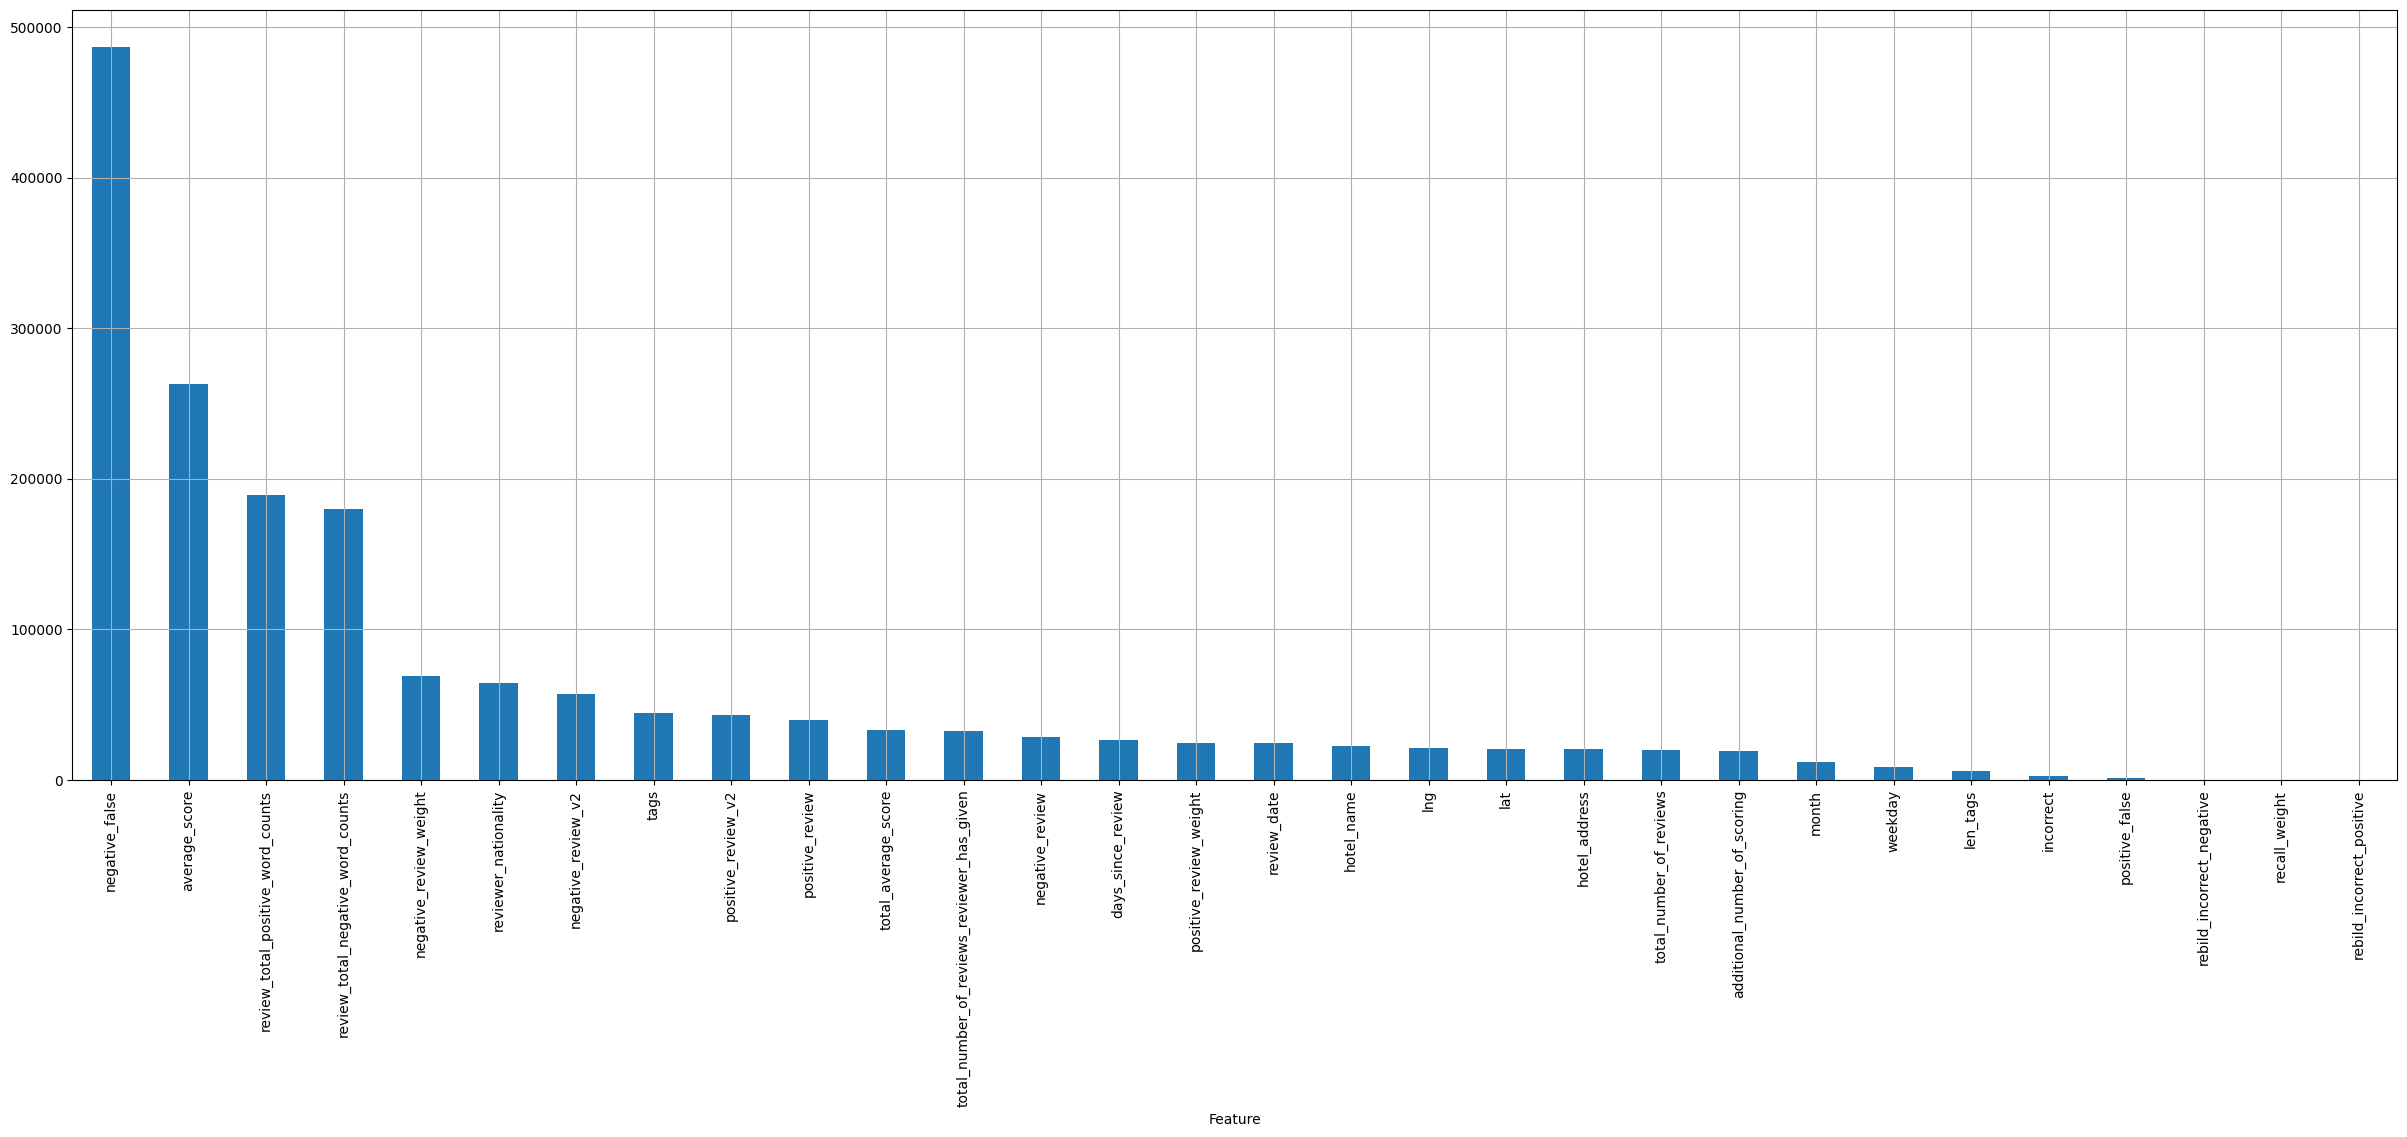

In [20]:
# Первоначальный анализ веса признаков влияющих на таргет в моделе
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

Старт 26:24:19
Завершено 26:31:54


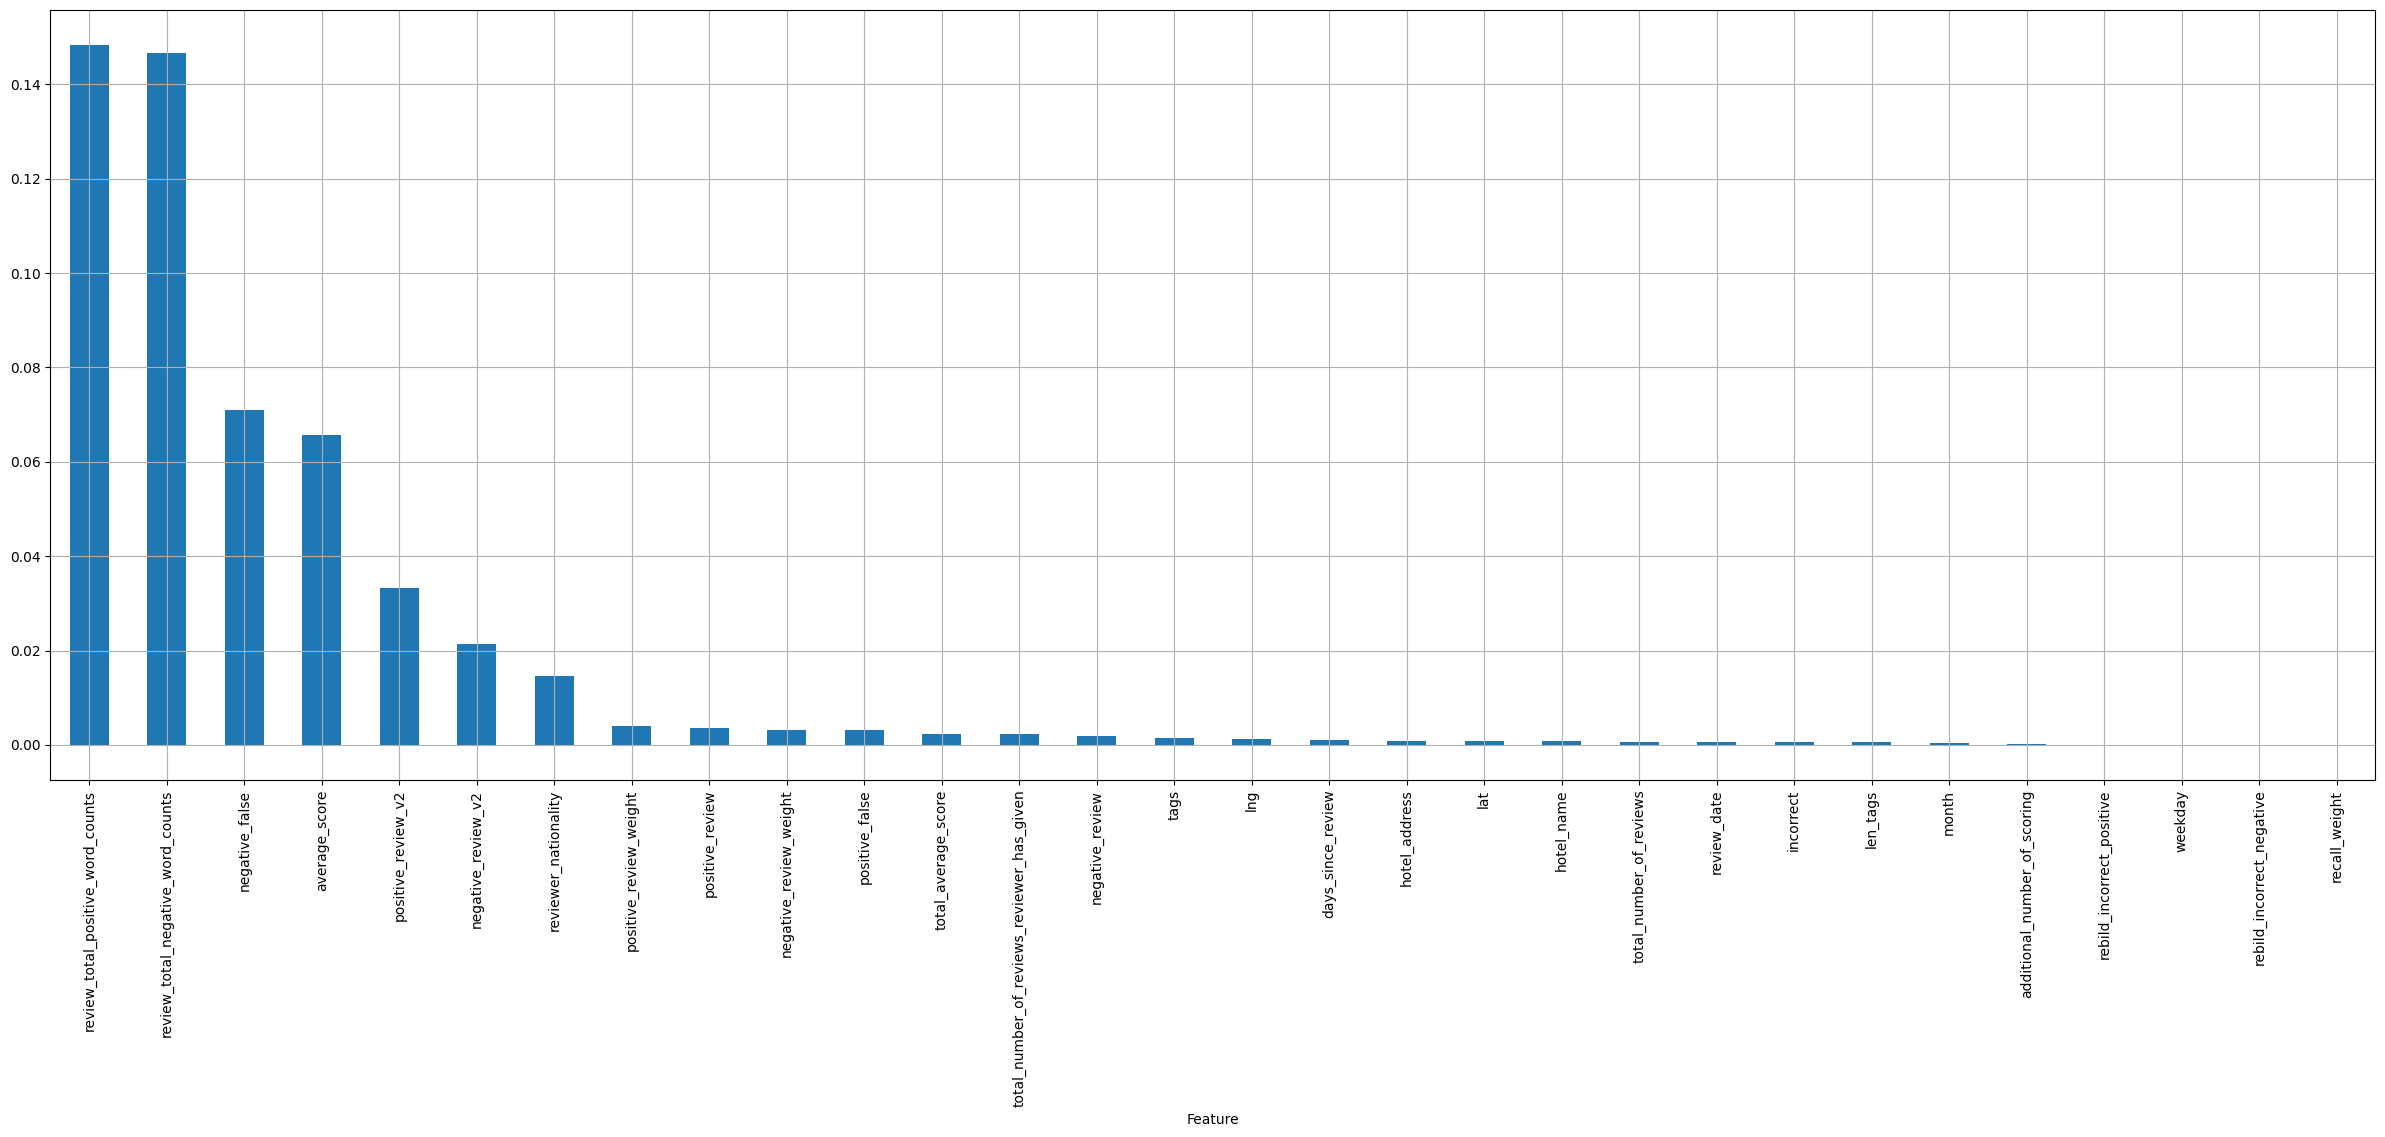

In [21]:
# Реальный вес признаков влияющих на таргет в моделе
print('Старт', f'{datetime.datetime.now().hour}:{datetime.datetime.now().minute}:{datetime.datetime.now().second}')
accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)
print('Завершено', f'{datetime.datetime.now().hour}:{datetime.datetime.now().minute}:{datetime.datetime.now().second}')


In [23]:
# предикт на новых данных и запись в submission
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')
submission[TARGET_NAME] = test_pred.data[:, 0]
submission.to_csv('submission.csv', index = False)
print('Завершено', f'{datetime.datetime.now().hour}:{datetime.datetime.now().minute}:{datetime.datetime.now().second}')

Prediction for te_data:
array([[8.593212 ],
       [7.8062   ],
       [8.190956 ],
       ...,
       [8.192542 ],
       [9.848062 ],
       [7.4997616]], dtype=float32)
Shape = (128935, 1)
Завершено 26:33:31


### Проверка на мультиколлинеарность
Как показала практика, колинеарность не влияет на конечный результат, а удаление признаков снижает score.

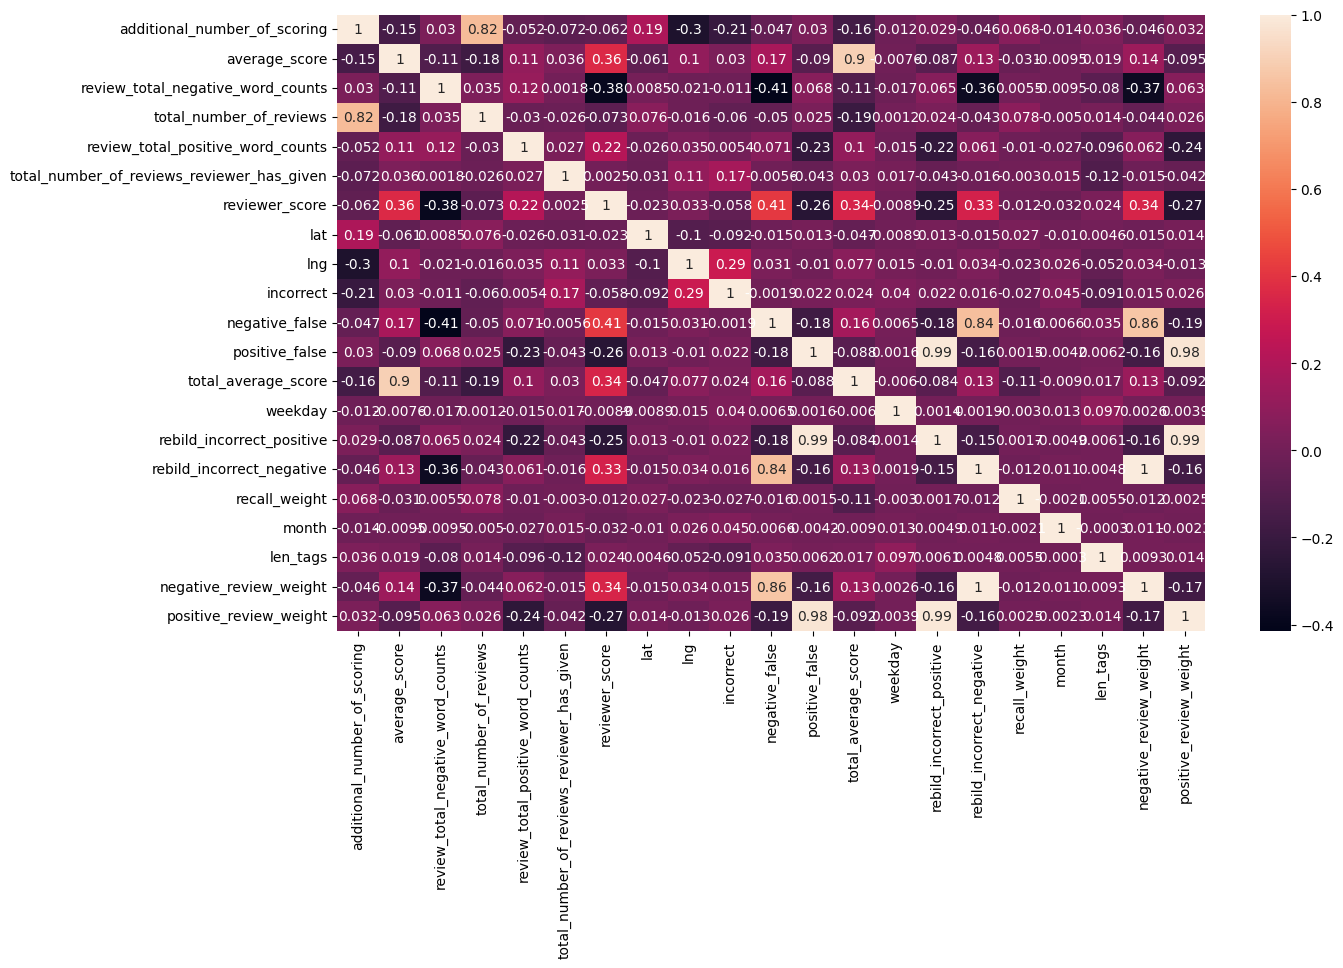

In [24]:
# hotels = hotels_train.drop('average_score', axis=1)
# hotels_train = hotels_train.drop(['additional_number_of_scoring', 'average_score'], axis=1) 
fig, axis = plt.subplots(figsize=(14,8))
cont = np.eye((2))
sns.heatmap(hotels_train.corr(), annot=True, fmt=".2g")
fig;